In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

#from helper2 import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

import torchvision

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from helpers_nn import *

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### MNIST dataset
The MNIST dataset is loaded.

In [3]:
trainset = datasets.MNIST('', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
print("Training and test sets information is displayed.\n\n")
print("Trainset:\n",trainset)
print("Testset:\n",valset)

Training and test sets information is displayed.


Trainset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Testset:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: PATH_TO_STORE_TESTSET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [12]:
print(valloader)
len(valloader)

157

64 images in each batch and each image has a dimension of 28 x 28 pixels


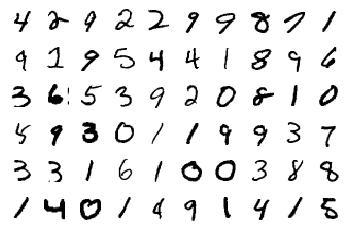

In [4]:
# A subset of a batch is plotted to show a sample of the dataset. 
dataiter = iter(trainloader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Neural Network 

### Model definition
The model is defined, specifying the structure of the neural network.

### Model A: FCNN
Fully connected neural network, with hidden layer structure through vector *hidden_sizes*.

In [7]:
# Input and output sizes and network structure are defined.
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
print(modelA)

# Loss of the model is defined.
criterion = nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Model B: CNN
Convolutional neural network composed of two convolutional layers and two fully connected layers.

In [9]:
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
# Depending on the size of the image, a CNN model is built.
modelB=ConvNet(image_size)
print(modelB)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


### Training
The model is trained with SGD, used as baseline.

In [10]:
lr=0.003
momentum=0.9
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 9

train_losses, test_losses = optimize_CNN(optimizer, epochs, trainloader,valloader, lr, momentum, model, criterion)

Epoch 0
Training loss: 0.38584952708532305
Test loss: 0.08746497263052282 

Epoch 1
Training loss: 0.07693479793058879
Test loss: 0.053723473810727236 

Epoch 2
Training loss: 0.055303009720628404
Test loss: 0.04015711514623302 

Epoch 3
Training loss: 0.04458361562254078
Test loss: 0.03635806571039709 

Epoch 4
Training loss: 0.03858139327685557
Test loss: 0.03548024506100519 

Epoch 5
Training loss: 0.032913274816989496
Test loss: 0.03240839861093125 

Epoch 6
Training loss: 0.029416398079790324
Test loss: 0.0280506892031901 

Epoch 7
Training loss: 0.026020623606702646
Test loss: 0.02815074169160027 

Epoch 8
Training loss: 0.02286787969644801
Test loss: 0.032481624129944583 


Training Time (in minutes) = 15.881343054771424


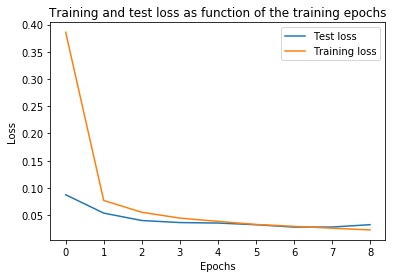

In [11]:
plt.plot(test_losses,label='Test loss')
plt.plot(train_losses,label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and test loss as function of the training epochs')
plt.legend()

In [68]:
# This cell gives insight into how the prediction process works.
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Probabilities computed for each digit =\n",probab)
print("\nPredicted Digit =", probab.index(max(probab)))
print("Actual Digit =",labels[0].numpy())
#view_classify(img.view(1, 28, 28), ps)

Probabilities computed for each digit =
 [4.632957e-06, 5.140131e-05, 1.9065958e-05, 0.9926165, 0.0036483733, 0.00041103543, 1.1146047e-05, 0.0031636038, 1.10238325e-05, 6.3191e-05]

Predicted Digit = 3
Actual Digit = 3


In [52]:
probabilities, predicctions = predict_one_img(valloader,model)

Probabilities computed for each digit =
 [3.0963787e-16, 1.6100303e-16, 1.0272674e-13, 2.8647522e-09, 2.0396508e-14, 2.2982263e-12, 8.063883e-14, 4.531942e-22, 1.0, 1.0583134e-12]

Predicted Digit = 8
Actual Digit = 8


### Test
The trained model is used to predict the labels of the test set, and the model performance is evaluated.

In [53]:
# Accuracy obtained for FCNN
accuracy = accuracy_test(valloader, model)

Number Of Images Tested = 10000

Model Accuracy = 0.9803


In [20]:
# Accuracy obtained for CNN
accuracy=accuracy_test_CNN(valloader,modelB)

Number Of Images Tested = 10000
Model Accuracy = 0.9903


### Hyperparameter optimization

In [ ]:
epochs = 3
blr = best_learning_rate(input_size, output_size, trainloader, valloader)